In [ ]:
import os
import cv2
import random
import shutil
import pathlib
import numpy as np
import pandas as pd
from glob import glob
from tqdm import tqdm
from PIL import Image
import tensorflow as tf
from shutil import copyfile
import tensorflow_hub as hub
import matplotlib.pylab as plt
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
from google.colab import drive
from google.colab import files

In [ ]:
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten,Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential

In [ ]:
!pip install keras

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
source_path = '/content/drive/MyDrive/Data/dataset/'
source_path_lima_asli = os.path.join(source_path, 'uang50asli')
source_path_seratus_asli = os.path.join(source_path, 'uang100asli')
source_path_lima_palsu = os.path.join(source_path, 'uang50palsu')
source_path_seratus_palsu = os.path.join(source_path, 'uang100palsu')

In [ ]:
# Fungsi untuk membuat folder

def createFolder(root_path):

  print(f"Creating \'{root_path}\' directory.")
  os.makedirs(root_path)

  seratus_asli_path = os.path.join(root_path, 'uang100asli')
  os.makedirs(seratus_asli_path)
  print(f"\nUang 100 Asli directory created as \'{seratus_asli_path}\'.")

  seratus_palsu_path = os.path.join(root_path, 'uang100palsu')
  os.makedirs(seratus_palsu_path)
  print(f"\nUang 100 Palsu directory created as \'{seratus_palsu_path}\'.")

  lima_asli_path = os.path.join(root_path, 'uang50asli')
  os.makedirs(lima_asli_path)
  print(f"\nUang 50 Asli directory created as \'{lima_asli_path}\'.")

  lima_palsu_path = os.path.join(root_path, 'uang50palsu')
  os.makedirs(lima_palsu_path)
  print(f"\nUang 50 Palsu directory created as \'{lima_palsu_path}\'.")

In [ ]:
root_dir = '/content/data'
# Empty directory to prevent FileExistsError is the function is run several times
if os.path.exists(root_dir):
  shutil.rmtree(root_dir)

try:
  createFolder(root_path=root_dir)
except FileExistsError:
  print("You should not be seeing this since the upper directory is removed beforehand")

Creating '/content/data' directory.

Uang 100 Asli directory created as '/content/data/uang100asli'.

Uang 100 Palsu directory created as '/content/data/uang100palsu'.

Uang 50 Asli directory created as '/content/data/uang50asli'.

Uang 50 Palsu directory created as '/content/data/uang50palsu'.


In [ ]:
def importData(source, destination):
   files = []
   for filename in os.listdir(source):
    file = source + filename
        
    if os.path.getsize(file) > 0:
      files.append(filename)
    else:
      print(filename + " is zero length, so ignoring.")
    
    for filename in files:
      this_file = source + filename
      destination_path = destination + filename
      copyfile(this_file, destination_path)

In [ ]:
source_100_asli = '/content/drive/MyDrive/Data/dataset/uang100asli/'
source_100_palsu = '/content/drive/MyDrive/Data/dataset/uang100palsu/'
source_50_asli = '/content/drive/MyDrive/Data/dataset/uang50asli/'
source_50_palsu = '/content/drive/MyDrive/Data/dataset/uang50palsu/'

destination_100_asli = '/content/data/uang100asli/'
destination_100_palsu = '/content/data/uang100palsu/'
destination_50_asli = '/content/data/uang50asli/'
destination_50_palsu = '/content/data/uang50palsu/'

In [ ]:
importData(source_100_asli, destination_100_asli)
importData(source_100_palsu, destination_100_palsu)
importData(source_50_asli, destination_50_asli)
importData(source_50_palsu, destination_50_palsu)

In [ ]:
def imageAugmentation(source):
  files = []
  for filename in os.listdir(source):
    file = source + filename
        
    if os.path.getsize(file) > 0:
      files.append(filename)
    else:
      print(filename + " is zero length, so ignoring.")
  num = len(files) + 1
  images = glob(source+'*')

  for path in images:
    img = Image.open(path)
    img = img.resize((224,224))
    mirimg = img.transpose(Image.FLIP_LEFT_RIGHT)
    mirimg.save(source+str(num)+'.jpg')
    num+=1
    # lrotimg = img.rotate(90, Image.NEAREST, expand = 1)
    # lrotimg.save(source+str(num)+'.jpg')
    # num+=1=

In [ ]:
imageAugmentation(destination_100_asli)
imageAugmentation(destination_100_palsu)
imageAugmentation(destination_50_asli)
imageAugmentation(destination_50_palsu)

# VGG-Full-60:20:20

In [ ]:
# Fungsi untuk membuat folder training, validation, testing

def create_train_test_dirs(root_path):

  print(f"Creating \'{root_path}\' directory.")
  os.makedirs(root_path)

  training_dir = os.path.join(root_path, 'training')
  os.makedirs(training_dir)
  print(f"\nTraining directory created as \'{training_dir}\'.")

  validation_dir = os.path.join(root_path, 'validation')
  os.makedirs(validation_dir)
  print(f"\nValidation directory created as \'{validation_dir}\'.")

  testing_dir = os.path.join(root_path, 'testing')
  os.makedirs(testing_dir)
  print(f"\nTesting directory created as \'{testing_dir}\'.")

  print("\nCreating the subfolders for storing fake and real money images.")
  
  training_real_lima_dir = os.path.join(training_dir, "money50real")
  training_real_seratus_dir = os.path.join(training_dir, "money100real")
  training_fake_lima_dir = os.path.join(training_dir, "money50fake")
  training_fake_seratus_dir = os.path.join(training_dir, "money100fake")
  os.makedirs(training_real_lima_dir)
  os.makedirs(training_real_seratus_dir)
  os.makedirs(training_fake_lima_dir)
  os.makedirs(training_fake_seratus_dir)
  print(f"\'{training_real_lima_dir}\' and \'{training_real_seratus_dir}\' created.")
  print(f"\'{training_fake_lima_dir}\' and \'{training_fake_seratus_dir}\' created.")

  validation_real_lima_dir = os.path.join(validation_dir, "money50real")
  validation_real_seratus_dir = os.path.join(validation_dir, "money100real")
  validation_fake_lima_dir = os.path.join(validation_dir, "money50fake")
  validation_fake_seratus_dir = os.path.join(validation_dir, "money100fake")
  os.makedirs(validation_real_lima_dir)
  os.makedirs(validation_real_seratus_dir)
  os.makedirs(validation_fake_lima_dir)
  os.makedirs(validation_fake_seratus_dir)
  print(f"\'{validation_real_lima_dir}\' and \'{validation_real_seratus_dir}\' created.")
  print(f"\'{validation_fake_lima_dir}\' and \'{validation_fake_seratus_dir}\' created.")

  testing_real_lima_dir = os.path.join(testing_dir, "money50real")
  testing_real_seratus_dir = os.path.join(testing_dir, "money100real")
  testing_fake_lima_dir = os.path.join(testing_dir, "money50fake")
  testing_fake_seratus_dir = os.path.join(testing_dir, "money100fake")
  os.makedirs(testing_real_lima_dir)
  os.makedirs(testing_real_seratus_dir)
  os.makedirs(testing_fake_lima_dir)
  os.makedirs(testing_fake_seratus_dir)
  print(f"\'{testing_real_lima_dir}\' and \'{testing_real_seratus_dir}\' created.")
  print(f"\'{testing_fake_lima_dir}\' and \'{testing_fake_seratus_dir}\' created.")

In [ ]:
# Init directory root_dir
root_dir = '/content/model1'

# Empty directory to prevent FileExistsError is the function is run several times
if os.path.exists(root_dir):
  shutil.rmtree(root_dir)

try:
  create_train_test_dirs(root_path=root_dir)
except FileExistsError:
  print("You should not be seeing this since the upper directory is removed beforehand")

Creating '/content/model1' directory.

Training directory created as '/content/model1/training'.

Validation directory created as '/content/model1/validation'.

Testing directory created as '/content/model1/testing'.

Creating the subfolders for storing fake and real money images.
'/content/model1/training/money50real' and '/content/model1/training/money100real' created.
'/content/model1/training/money50fake' and '/content/model1/training/money100fake' created.
'/content/model1/validation/money50real' and '/content/model1/validation/money100real' created.
'/content/model1/validation/money50fake' and '/content/model1/validation/money100fake' created.
'/content/model1/testing/money50real' and '/content/model1/testing/money100real' created.
'/content/model1/testing/money50fake' and '/content/model1/testing/money100fake' created.


In [ ]:
# Splitting files into training, testing, validation

def split_data(SOURCE, TRAINING, VALIDATION, TESTING, SPLIT_SIZE):
  
  files = []
  for filename in os.listdir(SOURCE):
    file = SOURCE + filename
        
    if os.path.getsize(file) > 0:
      files.append(filename)
    else:
      print(filename + " is zero length, so ignoring.")

  training_length = int(len(files) * SPLIT_SIZE)
  validation_length_dep = int(len(files) - training_length)
  validation_length = int(validation_length_dep/2)
  testing_length = int(len(files) - validation_length)
  shuffled_set = random.sample(files, len(files))
  training_set = shuffled_set[0:training_length]
  validation_set = shuffled_set[-validation_length_dep:-validation_length]
  testing_set = shuffled_set[testing_length:]
    
  for filename in training_set:
    this_file = SOURCE + filename
    destination = TRAINING + filename
    copyfile(this_file, destination)
  
  for filename in validation_set:
    this_file = SOURCE + filename
    destination = VALIDATION + filename
    copyfile(this_file, destination)
        
  for filename in testing_set:
    this_file = SOURCE + filename
    destination = TESTING + filename
    copyfile(this_file, destination)

In [ ]:
REAL_LIMA_SOURCE_DIR = '/content/data/uang50asli/'
FAKE_LIMA_SOURCE_DIR = '/content/data/uang50palsu/'
REAL_SERATUS_SOURCE_DIR = '/content/data/uang100asli/'
FAKE_SERATUS_SOURCE_DIR = '/content/data/uang100palsu/'

TRAINING_DIR = "/content/model1/training/"
VALIDATION_DIR = "/content/model1/validation/"
TESTING_DIR = "/content/model1/testing/"

In [ ]:
# Define directories path

TRAINING_REAL_LIMA_DIR = os.path.join(TRAINING_DIR, "money50real/")
VALIDATION_REAL_LIMA_DIR = os.path.join(VALIDATION_DIR, "money50real/")
TESTING_REAL_LIMA_DIR = os.path.join(TESTING_DIR, "money50real/")

TRAINING_REAL_SERATUS_DIR = os.path.join(TRAINING_DIR, "money100real/")
VALIDATION_REAL_SERATUS_DIR = os.path.join(VALIDATION_DIR, "money100real/")
TESTING_REAL_SERATUS_DIR = os.path.join(TESTING_DIR, "money100real/")

TRAINING_FAKE_LIMA_DIR = os.path.join(TRAINING_DIR, "money50fake/")
VALIDATION_FAKE_LIMA_DIR = os.path.join(VALIDATION_DIR, "money50fake/")
TESTING_FAKE_LIMA_DIR = os.path.join(TESTING_DIR, "money50fake/")

TRAINING_FAKE_SERATUS_DIR = os.path.join(TRAINING_DIR, "money100fake/")
VALIDATION_FAKE_SERATUS_DIR = os.path.join(VALIDATION_DIR, "money100fake/")
TESTING_FAKE_SERATUS_DIR = os.path.join(TESTING_DIR, "money100fake/")

In [ ]:
# Run split data function

# Define proportion of images used for training
split_size = .6

# Empty directories in case you run this cell multiple times
if len(os.listdir(TRAINING_REAL_LIMA_DIR)) > 0:
  for file in os.scandir(TRAINING_REAL_LIMA_DIR):
    os.remove(file.path)
if len(os.listdir(TRAINING_REAL_SERATUS_DIR)) > 0:
  for file in os.scandir(TRAINING_REAL_SERATUS_DIR):
    os.remove(file.path)
if len(os.listdir(TRAINING_FAKE_LIMA_DIR)) > 0:
  for file in os.scandir(TRAINING_FAKE_LIMA_DIR):
    os.remove(file.path)
if len(os.listdir(TRAINING_FAKE_SERATUS_DIR)) > 0:
  for file in os.scandir(TRAINING_FAKE_SERATUS_DIR):
    os.remove(file.path)

if len(os.listdir(VALIDATION_REAL_LIMA_DIR)) > 0:
  for file in os.scandir(VALIDATION_REAL_LIMA_DIR):
    os.remove(file.path)
if len(os.listdir(VALIDATION_REAL_SERATUS_DIR)) > 0:
  for file in os.scandir(VALIDATION_REAL_SERATUS_DIR):
    os.remove(file.path)
if len(os.listdir(VALIDATION_FAKE_LIMA_DIR)) > 0:
  for file in os.scandir(VALIDATION_FAKE_LIMA_DIR):
    os.remove(file.path)
if len(os.listdir(VALIDATION_FAKE_SERATUS_DIR)) > 0:
  for file in os.scandir(VALIDATION_FAKE_SERATUS_DIR):
    os.remove(file.path)

if len(os.listdir(TESTING_REAL_LIMA_DIR)) > 0:
  for file in os.scandir(TESTING_REAL_LIMA_DIR):
    os.remove(file.path)
if len(os.listdir(TESTING_REAL_SERATUS_DIR)) > 0:
  for file in os.scandir(TESTING_REAL_SERATUS_DIR):
    os.remove(file.path)
if len(os.listdir(TESTING_FAKE_LIMA_DIR)) > 0:
  for file in os.scandir(TESTING_FAKE_LIMA_DIR):
    os.remove(file.path)
if len(os.listdir(TESTING_FAKE_SERATUS_DIR)) > 0:
  for file in os.scandir(TESTING_FAKE_SERATUS_DIR):
    os.remove(file.path)

In [ ]:
split_data(REAL_LIMA_SOURCE_DIR, TRAINING_REAL_LIMA_DIR, VALIDATION_REAL_LIMA_DIR, TESTING_REAL_LIMA_DIR, split_size)
split_data(REAL_SERATUS_SOURCE_DIR, TRAINING_REAL_SERATUS_DIR, VALIDATION_REAL_SERATUS_DIR, TESTING_REAL_SERATUS_DIR, split_size)
split_data(FAKE_LIMA_SOURCE_DIR, TRAINING_FAKE_LIMA_DIR, VALIDATION_FAKE_LIMA_DIR, TESTING_FAKE_LIMA_DIR, split_size)
split_data(FAKE_SERATUS_SOURCE_DIR, TRAINING_FAKE_SERATUS_DIR, VALIDATION_FAKE_SERATUS_DIR, TESTING_FAKE_SERATUS_DIR, split_size)

In [ ]:
# Train Images
print("===Training Images Dataset===\n")
pd.DataFrame(data=[len(os.listdir(TRAINING_REAL_LIMA_DIR)), len(os.listdir(TRAINING_REAL_SERATUS_DIR)), len(os.listdir(TRAINING_FAKE_LIMA_DIR)), len(os.listdir(TRAINING_FAKE_SERATUS_DIR))], index=['50.000 Asli', '100.000 Asli', '50.000 Palsu', '100.000 Palsu'], columns=['Total Images'])

===Training Images Dataset===



,Total Images
50.000 Asli,576
100.000 Asli,576
50.000 Palsu,360
100.000 Palsu,360


In [ ]:
# Testing Images
print("===Testing Images Dataset===\n")
pd.DataFrame(data=[len(os.listdir(TESTING_REAL_LIMA_DIR)), len(os.listdir(TESTING_REAL_SERATUS_DIR)), len(os.listdir(TESTING_FAKE_LIMA_DIR)), len(os.listdir(TESTING_FAKE_SERATUS_DIR))], index=['50.000 Asli', '100.000 Asli', '50.000 Palsu', '100.000 Palsu'], columns=['Total Images'])

===Testing Images Dataset===



,Total Images
50.000 Asli,192
100.000 Asli,192
50.000 Palsu,120
100.000 Palsu,120


In [ ]:
# Validation Images
print("===Validation Images Dataset===\n")
pd.DataFrame(data=[len(os.listdir(VALIDATION_REAL_LIMA_DIR)), len(os.listdir(VALIDATION_REAL_SERATUS_DIR)), len(os.listdir(VALIDATION_FAKE_LIMA_DIR)), len(os.listdir(VALIDATION_FAKE_SERATUS_DIR))], index=['50.000 Asli', '100.000 Asli', '50.000 Palsu', '100.000 Palsu'], columns=['Total Images'])

===Validation Images Dataset===



,Total Images
50.000 Asli,192
100.000 Asli,192
50.000 Palsu,120
100.000 Palsu,120


tfds.core.DatasetInfo(
    name='image_folder',
    full_name='image_folder/1.0.0',
    description="""
    Generic image classification dataset.
    """,
    homepage='https://www.tensorflow.org/datasets/catalog/image_folder',
    data_path='/root/tensorflow_datasets/image_folder/1.0.0',
    file_format=tfrecord,
    download_size=Unknown size,
    dataset_size=Unknown size,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'image/filename': Text(shape=(), dtype=string),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=4),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'testing': <SplitInfo num_examples=624, num_shards=1>,
        'training': <SplitInfo num_examples=1872, num_shards=1>,
        'validation': <SplitInfo num_examples=624, num_shards=1>,
    },
    citation="""""",
)


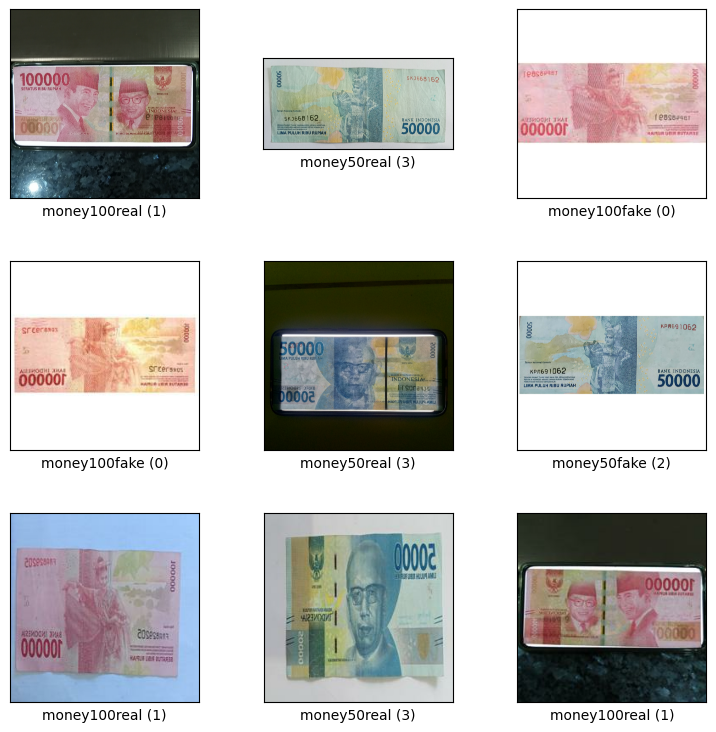

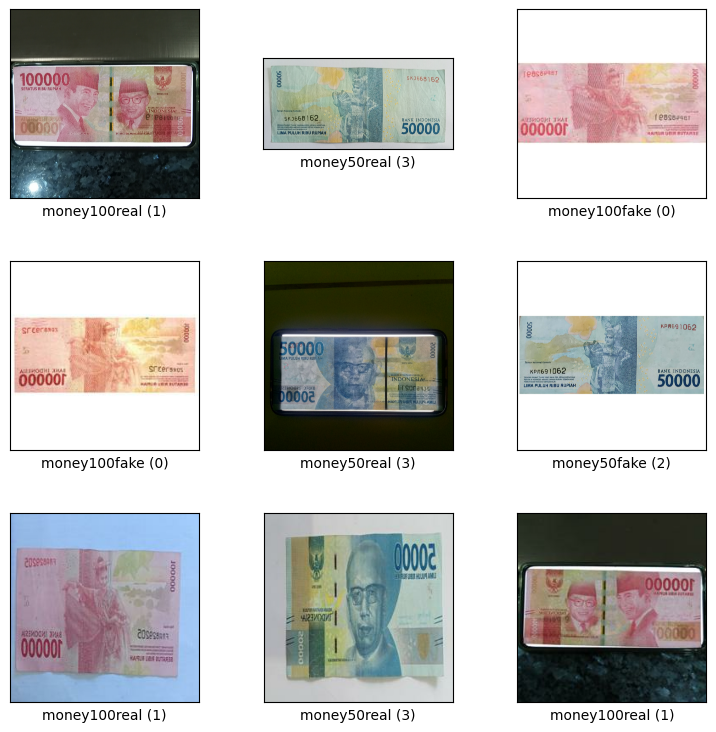

In [ ]:
# Load dataset menggunakan tfds.ImageFolder
import tensorflow_datasets as tfds

builder = tfds.ImageFolder('/content/model1/')
print(builder.info)  # num examples, labels... are automatically calculated
ds = builder.as_dataset(split='training', shuffle_files=True, as_supervised=True)
tfds.show_examples(ds, builder.info)

In [ ]:
def insertArray(path, array):
  for folder in os.listdir(path):
    sub_path=path+"/"+folder
    for img in os.listdir(sub_path):
        image_path=sub_path+"/"+img
        img_arr=cv2.imread(image_path)
        img_arr=cv2.resize(img_arr,(224,224))
        array.append(cv2.cvtColor(img_arr, cv2.COLOR_BGR2RGB))

train_path=TRAINING_DIR
test_path=VALIDATION_DIR
val_path=TESTING_DIR

train_x=[]
test_x=[]
val_x=[]

insertArray(train_path, train_x)
insertArray(test_path, test_x)
insertArray(val_path, val_x)

In [ ]:
train_x=np.array(train_x)
test_x=np.array(test_x)
val_x=np.array(val_x)

In [ ]:
train_x=train_x/255.0
test_x=test_x/255.0
val_x=val_x/255.0

In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1. / 255)
test_datagen = ImageDataGenerator(
    rescale=1. / 255)
val_datagen = ImageDataGenerator(
    rescale=1. / 255)

In [ ]:
# Class mode is set to sparse because the image samples are belong to exactly one class
training_set = train_datagen.flow_from_directory(train_path,
                                                 target_size = (224, 224),
                                                 batch_size = 32,
                                                 class_mode = 'sparse')
test_set = test_datagen.flow_from_directory(test_path,
                                            target_size = (224, 224),
                                            batch_size = 32,
                                            class_mode = 'sparse')
val_set = val_datagen.flow_from_directory(val_path,
                                            target_size = (224, 224),
                                            batch_size = 32,
                                            class_mode = 'sparse')

Found 1872 images belonging to 4 classes.
Found 624 images belonging to 4 classes.
Found 624 images belonging to 4 classes.


In [ ]:
train_y=training_set.classes
test_y=test_set.classes
val_y=val_set.classes

In [ ]:
training_set.class_indices

{'money100fake': 0, 'money100real': 1, 'money50fake': 2, 'money50real': 3}

In [ ]:
train_y.shape,test_y.shape,val_y.shape

((1872,), (624,), (624,))

In [ ]:
vgg = VGG19(input_shape=(224, 224) + tuple([3]), weights='imagenet', include_top=False)

80134624/80134624 [==============================] - 4s 0us/step


In [ ]:
#do not train the pre-trained layers of VGG-19
for layer in vgg.layers:
    layer.trainable = False

In [ ]:
x = Flatten()(vgg.output)

In [ ]:
#adding output layer.Softmax classifier is used as it is multi-class classification
prediction = Dense(4, activation='softmax')(x)

model = Model(inputs=vgg.input, outputs=prediction)

In [ ]:
# view the structure of the model
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
model.compile(
  loss='sparse_categorical_crossentropy',
  optimizer="adam",
  metrics=['accuracy']
)

In [ ]:
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=15)
mc = ModelCheckpoint('vggfull_1.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True) 

In [ ]:
# fit the model
history = model.fit(
  train_x,
  train_y,
  validation_data=(val_x,val_y),
  epochs=100,
  callbacks=[mc],
  batch_size=32,shuffle=True)

Epoch 1/100
59/59 [==============================] - ETA: 0s - loss: 0.6201 - accuracy: 0.7516
Epoch 1: val_accuracy improved from -inf to 0.87660, saving model to vggfull_1.h5
59/59 [==============================] - 31s 278ms/step - loss: 0.6201 - accuracy: 0.7516 - val_loss: 0.3618 - val_accuracy: 0.8766
Epoch 2/100
59/59 [==============================] - ETA: 0s - loss: 0.3293 - accuracy: 0.8638
Epoch 2: val_accuracy improved from 0.87660 to 0.88141, saving model to vggfull_1.h5
59/59 [==============================] - 14s 242ms/step - loss: 0.3293 - accuracy: 0.8638 - val_loss: 0.4501 - val_accuracy: 0.8814
Epoch 3/100
59/59 [==============================] - ETA: 0s - loss: 0.2622 - accuracy: 0.8825
Epoch 3: val_accuracy did not improve from 0.88141
59/59 [==============================] - 14s 240ms/step - loss: 0.2622 - accuracy: 0.8825 - val_loss: 0.3132 - val_accuracy: 0.8221
Epoch 4/100
59/59 [==============================] - ETA: 0s - loss: 0.2214 - accuracy: 0.8990
Epoch 

In [ ]:
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix
import numpy as np

#predict
y_pred=model.predict(test_x)
y_pred=np.argmax(y_pred,axis=1)

20/20 [==============================] - 3s 152ms/step


In [ ]:
model.evaluate(test_x,test_y,batch_size=32)

20/20 [==============================] - 3s 151ms/step - loss: 0.5478 - accuracy: 0.8670


[0.5477901101112366, 0.8669871687889099]

In [ ]:
#get classification report
print(classification_report(y_pred,test_y))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99       118
           1       0.68      0.86      0.76       152
           2       0.83      0.62      0.71       161
           3       1.00      0.99      1.00       193

    accuracy                           0.87       624
   macro avg       0.87      0.87      0.87       624
weighted avg       0.88      0.87      0.87       624



In [ ]:
from sklearn.metrics import confusion_matrix

#Generate the confusion matrix
cf_matrix = confusion_matrix(test_y, y_pred)

print(cf_matrix)

[[118   1   0   1]
 [  0 131  61   0]
 [  0  20 100   0]
 [  0   0   0 192]]


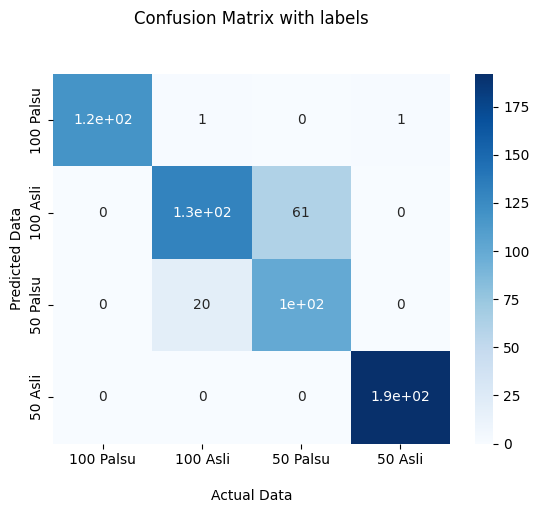

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues')

ax.set_title('Confusion Matrix with labels\n\n');
ax.set_xlabel('\nActual Data')
ax.set_ylabel('Predicted Data');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['100 Palsu','100 Asli', '50 Palsu', '50 Asli'])
ax.yaxis.set_ticklabels(['100 Palsu','100 Asli', '50 Palsu', '50 Asli'])

## Display the visualization of the Confusion Matrix.
plt.show()

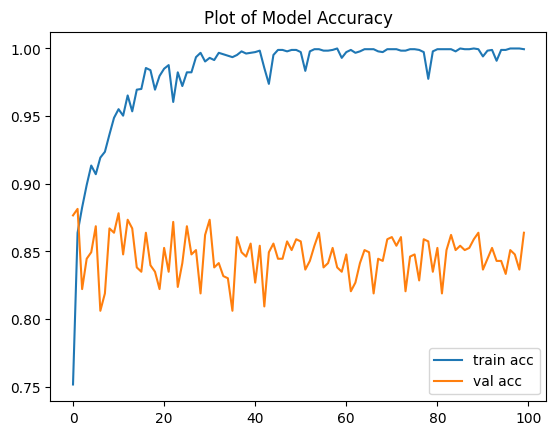

In [ ]:
# accuracies
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.title('Plot of Model Accuracy')
plt.legend()
plt.savefig('vgg-full-1-acc.png')
plt.show()

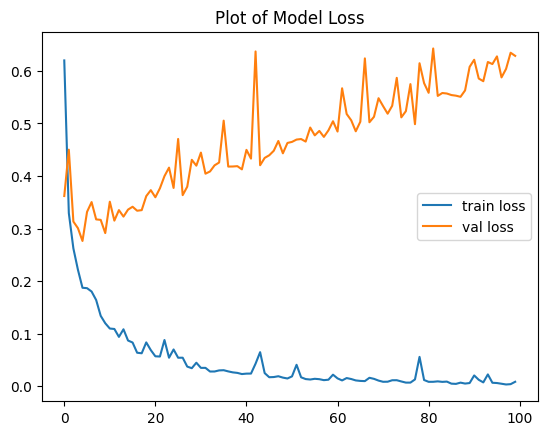

In [ ]:
# loss
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.title('Plot of Model Loss')
plt.legend()
plt.savefig('vgg-full-1-loss.png')
plt.show()

# VGG-Full-70:15:15

In [ ]:
# Model kedua untuk Arsitektur MobileNetV2 - Full Dataset - Split 80:10:10
root_dir = '/content/model2'

# Empty directory to prevent FileExistsError is the function is run several times
if os.path.exists(root_dir):
  shutil.rmtree(root_dir)

try:
  create_train_test_dirs(root_path=root_dir)
except FileExistsError:
  print("You should not be seeing this since the upper directory is removed beforehand")

Creating '/content/model2' directory.

Training directory created as '/content/model2/training'.

Validation directory created as '/content/model2/validation'.

Testing directory created as '/content/model2/testing'.

Creating the subfolders for storing fake and real money images.
'/content/model2/training/money50real' and '/content/model2/training/money100real' created.
'/content/model2/training/money50fake' and '/content/model2/training/money100fake' created.
'/content/model2/validation/money50real' and '/content/model2/validation/money100real' created.
'/content/model2/validation/money50fake' and '/content/model2/validation/money100fake' created.
'/content/model2/testing/money50real' and '/content/model2/testing/money100real' created.
'/content/model2/testing/money50fake' and '/content/model2/testing/money100fake' created.


In [ ]:
TRAINING_DIR = "/content/model2/training/"
VALIDATION_DIR = "/content/model2/validation/"
TESTING_DIR = "/content/model2/testing/"

In [ ]:
# Define directories path

TRAINING_REAL_LIMA_DIR = os.path.join(TRAINING_DIR, "money50real/")
VALIDATION_REAL_LIMA_DIR = os.path.join(VALIDATION_DIR, "money50real/")
TESTING_REAL_LIMA_DIR = os.path.join(TESTING_DIR, "money50real/")

TRAINING_REAL_SERATUS_DIR = os.path.join(TRAINING_DIR, "money100real/")
VALIDATION_REAL_SERATUS_DIR = os.path.join(VALIDATION_DIR, "money100real/")
TESTING_REAL_SERATUS_DIR = os.path.join(TESTING_DIR, "money100real/")

TRAINING_FAKE_LIMA_DIR = os.path.join(TRAINING_DIR, "money50fake/")
VALIDATION_FAKE_LIMA_DIR = os.path.join(VALIDATION_DIR, "money50fake/")
TESTING_FAKE_LIMA_DIR = os.path.join(TESTING_DIR, "money50fake/")

TRAINING_FAKE_SERATUS_DIR = os.path.join(TRAINING_DIR, "money100fake/")
VALIDATION_FAKE_SERATUS_DIR = os.path.join(VALIDATION_DIR, "money100fake/")
TESTING_FAKE_SERATUS_DIR = os.path.join(TESTING_DIR, "money100fake/")

In [ ]:
# Empty directories in case you run this cell multiple times
if len(os.listdir(TRAINING_REAL_LIMA_DIR)) > 0:
  for file in os.scandir(TRAINING_REAL_LIMA_DIR):
    os.remove(file.path)
if len(os.listdir(TRAINING_REAL_SERATUS_DIR)) > 0:
  for file in os.scandir(TRAINING_REAL_SERATUS_DIR):
    os.remove(file.path)
if len(os.listdir(TRAINING_FAKE_LIMA_DIR)) > 0:
  for file in os.scandir(TRAINING_FAKE_LIMA_DIR):
    os.remove(file.path)
if len(os.listdir(TRAINING_FAKE_SERATUS_DIR)) > 0:
  for file in os.scandir(TRAINING_FAKE_SERATUS_DIR):
    os.remove(file.path)

if len(os.listdir(VALIDATION_REAL_LIMA_DIR)) > 0:
  for file in os.scandir(VALIDATION_REAL_LIMA_DIR):
    os.remove(file.path)
if len(os.listdir(VALIDATION_REAL_SERATUS_DIR)) > 0:
  for file in os.scandir(VALIDATION_REAL_SERATUS_DIR):
    os.remove(file.path)
if len(os.listdir(VALIDATION_FAKE_LIMA_DIR)) > 0:
  for file in os.scandir(VALIDATION_FAKE_LIMA_DIR):
    os.remove(file.path)
if len(os.listdir(VALIDATION_FAKE_SERATUS_DIR)) > 0:
  for file in os.scandir(VALIDATION_FAKE_SERATUS_DIR):
    os.remove(file.path)

if len(os.listdir(TESTING_REAL_LIMA_DIR)) > 0:
  for file in os.scandir(TESTING_REAL_LIMA_DIR):
    os.remove(file.path)
if len(os.listdir(TESTING_REAL_SERATUS_DIR)) > 0:
  for file in os.scandir(TESTING_REAL_SERATUS_DIR):
    os.remove(file.path)
if len(os.listdir(TESTING_FAKE_LIMA_DIR)) > 0:
  for file in os.scandir(TESTING_FAKE_LIMA_DIR):
    os.remove(file.path)
if len(os.listdir(TESTING_FAKE_SERATUS_DIR)) > 0:
  for file in os.scandir(TESTING_FAKE_SERATUS_DIR):
    os.remove(file.path)

In [ ]:
# Run split data function
# Define proportion of images used for training
split_size = .7

split_data(REAL_LIMA_SOURCE_DIR, TRAINING_REAL_LIMA_DIR, VALIDATION_REAL_LIMA_DIR, TESTING_REAL_LIMA_DIR, split_size)
split_data(REAL_SERATUS_SOURCE_DIR, TRAINING_REAL_SERATUS_DIR, VALIDATION_REAL_SERATUS_DIR, TESTING_REAL_SERATUS_DIR, split_size)
split_data(FAKE_LIMA_SOURCE_DIR, TRAINING_FAKE_LIMA_DIR, VALIDATION_FAKE_LIMA_DIR, TESTING_FAKE_LIMA_DIR, split_size)
split_data(FAKE_SERATUS_SOURCE_DIR, TRAINING_FAKE_SERATUS_DIR, VALIDATION_FAKE_SERATUS_DIR, TESTING_FAKE_SERATUS_DIR, split_size)

In [ ]:
# Train Images
print("===Training Images Dataset===\n")
pd.DataFrame(data=[len(os.listdir(TRAINING_REAL_LIMA_DIR)), len(os.listdir(TRAINING_REAL_SERATUS_DIR)), len(os.listdir(TRAINING_FAKE_LIMA_DIR)), len(os.listdir(TRAINING_FAKE_SERATUS_DIR))], index=['50.000 Asli', '100.000 Asli', '50.000 Palsu', '100.000 Palsu'], columns=['Total Images'])

===Training Images Dataset===



,Total Images
50.000 Asli,672
100.000 Asli,672
50.000 Palsu,420
100.000 Palsu,420


In [ ]:
# Validation Images
print("===Validation Images Dataset===\n")
pd.DataFrame(data=[len(os.listdir(VALIDATION_REAL_LIMA_DIR)), len(os.listdir(VALIDATION_REAL_SERATUS_DIR)), len(os.listdir(VALIDATION_FAKE_LIMA_DIR)), len(os.listdir(VALIDATION_FAKE_SERATUS_DIR))], index=['50.000 Asli', '100.000 Asli', '50.000 Palsu', '100.000 Palsu'], columns=['Total Images'])

===Validation Images Dataset===



,Total Images
50.000 Asli,144
100.000 Asli,144
50.000 Palsu,90
100.000 Palsu,90


In [ ]:
# Testing Images
print("===Testing Images Dataset===\n")
pd.DataFrame(data=[len(os.listdir(TESTING_REAL_LIMA_DIR)), len(os.listdir(TESTING_REAL_SERATUS_DIR)), len(os.listdir(TESTING_FAKE_LIMA_DIR)), len(os.listdir(TESTING_FAKE_SERATUS_DIR))], index=['50.000 Asli', '100.000 Asli', '50.000 Palsu', '100.000 Palsu'], columns=['Total Images'])

===Testing Images Dataset===



,Total Images
50.000 Asli,144
100.000 Asli,144
50.000 Palsu,90
100.000 Palsu,90


tfds.core.DatasetInfo(
    name='image_folder',
    full_name='image_folder/1.0.0',
    description="""
    Generic image classification dataset.
    """,
    homepage='https://www.tensorflow.org/datasets/catalog/image_folder',
    data_path='/root/tensorflow_datasets/image_folder/1.0.0',
    file_format=tfrecord,
    download_size=Unknown size,
    dataset_size=Unknown size,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'image/filename': Text(shape=(), dtype=string),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=4),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'testing': <SplitInfo num_examples=468, num_shards=1>,
        'training': <SplitInfo num_examples=2184, num_shards=1>,
        'validation': <SplitInfo num_examples=468, num_shards=1>,
    },
    citation="""""",
)


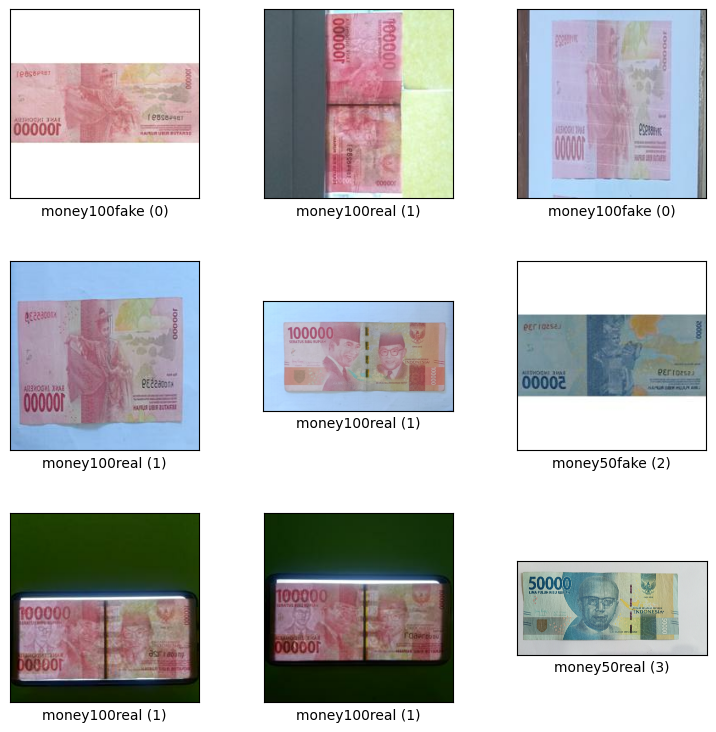

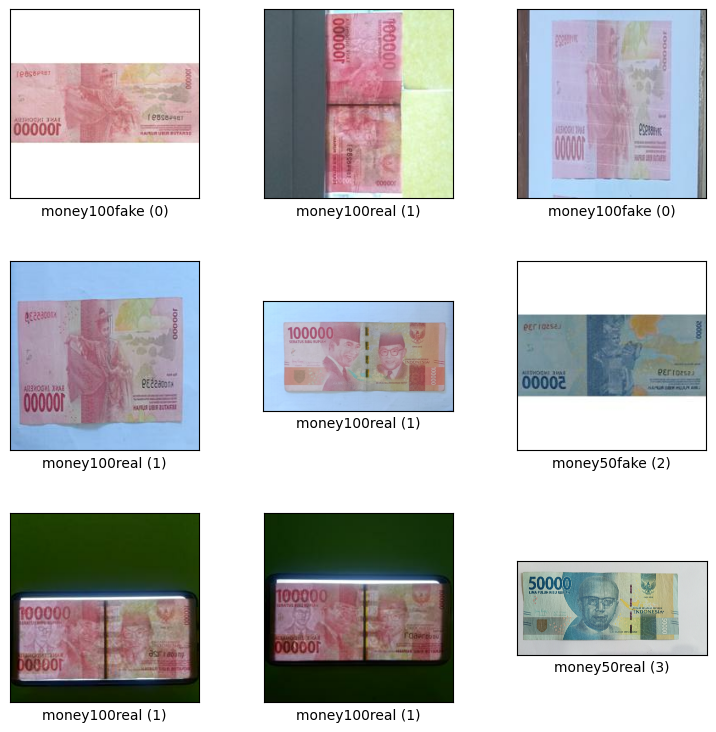

In [ ]:
# Load dataset menggunakan tfds.ImageFolder
import tensorflow_datasets as tfds

builder = tfds.ImageFolder('/content/model2/')
print(builder.info)  # num examples, labels... are automatically calculated
ds = builder.as_dataset(split='training', shuffle_files=True, as_supervised=True)
tfds.show_examples(ds, builder.info)

In [ ]:
train_path=TRAINING_DIR
test_path=VALIDATION_DIR
val_path=TESTING_DIR

In [ ]:
train_x=[]
test_x=[]
val_x=[]

insertArray(train_path, train_x)
insertArray(test_path, test_x)
insertArray(val_path, val_x)

In [ ]:
train_x=np.array(train_x)
test_x=np.array(test_x)
val_x=np.array(val_x)

In [ ]:
#Normalize Data
train_datagen = ImageDataGenerator(
    rescale=1. / 255)
test_datagen = ImageDataGenerator(
    rescale=1. / 255)
val_datagen = ImageDataGenerator(
    rescale=1. / 255)

In [ ]:
# Class mode is set to sparse because the image samples are belong to exactly one class
training_set = train_datagen.flow_from_directory(train_path,
                                                 target_size = (224, 224),
                                                 batch_size = 32,
                                                 class_mode = 'sparse')
test_set = test_datagen.flow_from_directory(test_path,
                                            target_size = (224, 224),
                                            batch_size = 32,
                                            class_mode = 'sparse')
val_set = val_datagen.flow_from_directory(val_path,
                                            target_size = (224, 224),
                                            batch_size = 32,
                                            class_mode = 'sparse')

Found 2184 images belonging to 4 classes.
Found 468 images belonging to 4 classes.
Found 468 images belonging to 4 classes.


In [ ]:
train_y=training_set.classes
test_y=test_set.classes
val_y=val_set.classes

In [ ]:
training_set.class_indices

{'money100fake': 0, 'money100real': 1, 'money50fake': 2, 'money50real': 3}

In [ ]:
train_y.shape,test_y.shape,val_y.shape

((2184,), (468,), (468,))

In [ ]:
vgg = VGG19(input_shape=(224, 224) + tuple([3]), weights='imagenet', include_top=False)

In [ ]:
#do not train the pre-trained layers of VGG-19
for layer in vgg.layers:
    layer.trainable = False

In [ ]:
x = Flatten()(vgg.output)

In [ ]:
#adding output layer.Softmax classifier is used as it is multi-class classification
prediction = Dense(4, activation='softmax')(x)

model = Model(inputs=vgg.input, outputs=prediction)

In [ ]:
model.compile(
  loss='sparse_categorical_crossentropy',
  optimizer="adam",
  metrics=['accuracy']
)

In [ ]:
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=15)
mc = ModelCheckpoint('vggfull_2.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True) 

In [ ]:
# fit the model
history = model.fit(
  train_x,
  train_y,
  validation_data=(val_x,val_y),
  epochs=100,
  callbacks=[mc],
  batch_size=32,shuffle=True)

Epoch 1/100
69/69 [==============================] - ETA: 0s - loss: 4.0943 - accuracy: 0.7798
Epoch 1: val_accuracy improved from -inf to 0.86325, saving model to vggfull_2.h5
69/69 [==============================] - 20s 256ms/step - loss: 4.0943 - accuracy: 0.7798 - val_loss: 2.9883 - val_accuracy: 0.8632
Epoch 2/100
69/69 [==============================] - ETA: 0s - loss: 2.0459 - accuracy: 0.8869
Epoch 2: val_accuracy did not improve from 0.86325
69/69 [==============================] - 13s 193ms/step - loss: 2.0459 - accuracy: 0.8869 - val_loss: 3.5137 - val_accuracy: 0.8056
Epoch 3/100
69/69 [==============================] - ETA: 0s - loss: 1.1069 - accuracy: 0.9254
Epoch 3: val_accuracy did not improve from 0.86325
69/69 [==============================] - 14s 198ms/step - loss: 1.1069 - accuracy: 0.9254 - val_loss: 4.1861 - val_accuracy: 0.8526
Epoch 4/100
69/69 [==============================] - ETA: 0s - loss: 1.0043 - accuracy: 0.9341
Epoch 4: val_accuracy did not improve fr

In [ ]:
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix
import numpy as np

#predict
y_pred=model.predict(test_x)
y_pred=np.argmax(y_pred,axis=1)

15/15 [==============================] - 2s 148ms/step


In [ ]:
model.evaluate(test_x,test_y,batch_size=32)

15/15 [==============================] - 2s 147ms/step - loss: 12.1632 - accuracy: 0.8526


[12.163249015808105, 0.8525640964508057]

In [ ]:
#get classification report
print(classification_report(y_pred,test_y))

              precision    recall  f1-score   support

           0       0.97      1.00      0.98        87
           1       0.74      0.78      0.76       137
           2       0.68      0.62      0.65        98
           3       1.00      0.99      0.99       146

    accuracy                           0.85       468
   macro avg       0.85      0.85      0.85       468
weighted avg       0.85      0.85      0.85       468



In [ ]:
from sklearn.metrics import confusion_matrix

#Generate the confusion matrix
cf_matrix2 = confusion_matrix(test_y, y_pred)

print(cf_matrix2)

[[ 87   1   0   2]
 [  0 107  37   0]
 [  0  29  61   0]
 [  0   0   0 144]]


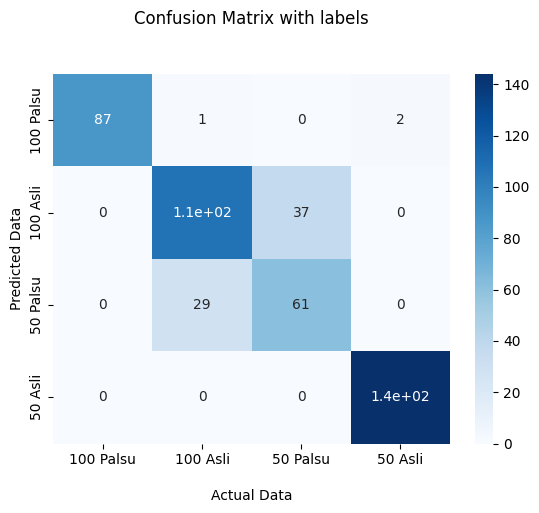

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

ax = sns.heatmap(cf_matrix2, annot=True, cmap='Blues')

ax.set_title('Confusion Matrix with labels\n\n');
ax.set_xlabel('\nActual Data')
ax.set_ylabel('Predicted Data');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['100 Palsu','100 Asli', '50 Palsu', '50 Asli'])
ax.yaxis.set_ticklabels(['100 Palsu','100 Asli', '50 Palsu', '50 Asli'])

## Display the visualization of the Confusion Matrix.
plt.show()

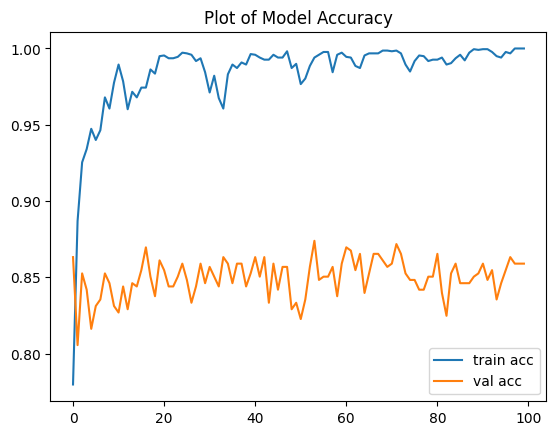

In [ ]:
# accuracies
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.title('Plot of Model Accuracy')
plt.legend()
plt.savefig('vgg-full-2-acc.png')
plt.show()

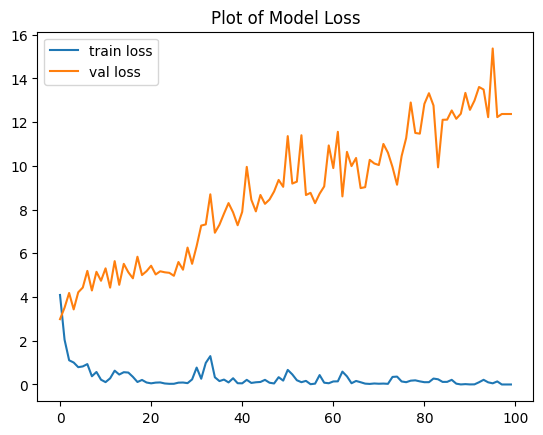

In [ ]:
# loss
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.title('Plot of Model Loss')
plt.legend()
plt.savefig('vgg-full-2-loss.png')
plt.show()

#VGG-Full-80:10:10


In [ ]:
# Model kedua untuk Arsitektur MobileNetV2 - Full Dataset - Split 80:10:10
root_dir = '/content/model3'

# Empty directory to prevent FileExistsError is the function is run several times
if os.path.exists(root_dir):
  shutil.rmtree(root_dir)

try:
  create_train_test_dirs(root_path=root_dir)
except FileExistsError:
  print("You should not be seeing this since the upper directory is removed beforehand")

Creating '/content/model3' directory.

Training directory created as '/content/model3/training'.

Validation directory created as '/content/model3/validation'.

Testing directory created as '/content/model3/testing'.

Creating the subfolders for storing fake and real money images.
'/content/model3/training/money50real' and '/content/model3/training/money100real' created.
'/content/model3/training/money50fake' and '/content/model3/training/money100fake' created.
'/content/model3/validation/money50real' and '/content/model3/validation/money100real' created.
'/content/model3/validation/money50fake' and '/content/model3/validation/money100fake' created.
'/content/model3/testing/money50real' and '/content/model3/testing/money100real' created.
'/content/model3/testing/money50fake' and '/content/model3/testing/money100fake' created.


In [ ]:
TRAINING_DIR = "/content/model3/training/"
VALIDATION_DIR = "/content/model3/validation/"
TESTING_DIR = "/content/model3/testing/"

In [ ]:
# Define directories path

TRAINING_REAL_LIMA_DIR = os.path.join(TRAINING_DIR, "money50real/")
VALIDATION_REAL_LIMA_DIR = os.path.join(VALIDATION_DIR, "money50real/")
TESTING_REAL_LIMA_DIR = os.path.join(TESTING_DIR, "money50real/")

TRAINING_REAL_SERATUS_DIR = os.path.join(TRAINING_DIR, "money100real/")
VALIDATION_REAL_SERATUS_DIR = os.path.join(VALIDATION_DIR, "money100real/")
TESTING_REAL_SERATUS_DIR = os.path.join(TESTING_DIR, "money100real/")

TRAINING_FAKE_LIMA_DIR = os.path.join(TRAINING_DIR, "money50fake/")
VALIDATION_FAKE_LIMA_DIR = os.path.join(VALIDATION_DIR, "money50fake/")
TESTING_FAKE_LIMA_DIR = os.path.join(TESTING_DIR, "money50fake/")

TRAINING_FAKE_SERATUS_DIR = os.path.join(TRAINING_DIR, "money100fake/")
VALIDATION_FAKE_SERATUS_DIR = os.path.join(VALIDATION_DIR, "money100fake/")
TESTING_FAKE_SERATUS_DIR = os.path.join(TESTING_DIR, "money100fake/")

In [ ]:
# Empty directories in case you run this cell multiple times
if len(os.listdir(TRAINING_REAL_LIMA_DIR)) > 0:
  for file in os.scandir(TRAINING_REAL_LIMA_DIR):
    os.remove(file.path)
if len(os.listdir(TRAINING_REAL_SERATUS_DIR)) > 0:
  for file in os.scandir(TRAINING_REAL_SERATUS_DIR):
    os.remove(file.path)
if len(os.listdir(TRAINING_FAKE_LIMA_DIR)) > 0:
  for file in os.scandir(TRAINING_FAKE_LIMA_DIR):
    os.remove(file.path)
if len(os.listdir(TRAINING_FAKE_SERATUS_DIR)) > 0:
  for file in os.scandir(TRAINING_FAKE_SERATUS_DIR):
    os.remove(file.path)

if len(os.listdir(VALIDATION_REAL_LIMA_DIR)) > 0:
  for file in os.scandir(VALIDATION_REAL_LIMA_DIR):
    os.remove(file.path)
if len(os.listdir(VALIDATION_REAL_SERATUS_DIR)) > 0:
  for file in os.scandir(VALIDATION_REAL_SERATUS_DIR):
    os.remove(file.path)
if len(os.listdir(VALIDATION_FAKE_LIMA_DIR)) > 0:
  for file in os.scandir(VALIDATION_FAKE_LIMA_DIR):
    os.remove(file.path)
if len(os.listdir(VALIDATION_FAKE_SERATUS_DIR)) > 0:
  for file in os.scandir(VALIDATION_FAKE_SERATUS_DIR):
    os.remove(file.path)

if len(os.listdir(TESTING_REAL_LIMA_DIR)) > 0:
  for file in os.scandir(TESTING_REAL_LIMA_DIR):
    os.remove(file.path)
if len(os.listdir(TESTING_REAL_SERATUS_DIR)) > 0:
  for file in os.scandir(TESTING_REAL_SERATUS_DIR):
    os.remove(file.path)
if len(os.listdir(TESTING_FAKE_LIMA_DIR)) > 0:
  for file in os.scandir(TESTING_FAKE_LIMA_DIR):
    os.remove(file.path)
if len(os.listdir(TESTING_FAKE_SERATUS_DIR)) > 0:
  for file in os.scandir(TESTING_FAKE_SERATUS_DIR):
    os.remove(file.path)

In [ ]:
# Run split data function
# Define proportion of images used for training
split_size = .8

split_data(REAL_LIMA_SOURCE_DIR, TRAINING_REAL_LIMA_DIR, VALIDATION_REAL_LIMA_DIR, TESTING_REAL_LIMA_DIR, split_size)
split_data(REAL_SERATUS_SOURCE_DIR, TRAINING_REAL_SERATUS_DIR, VALIDATION_REAL_SERATUS_DIR, TESTING_REAL_SERATUS_DIR, split_size)
split_data(FAKE_LIMA_SOURCE_DIR, TRAINING_FAKE_LIMA_DIR, VALIDATION_FAKE_LIMA_DIR, TESTING_FAKE_LIMA_DIR, split_size)
split_data(FAKE_SERATUS_SOURCE_DIR, TRAINING_FAKE_SERATUS_DIR, VALIDATION_FAKE_SERATUS_DIR, TESTING_FAKE_SERATUS_DIR, split_size)

In [ ]:
# Train Images
print("===Training Images Dataset===\n")
pd.DataFrame(data=[len(os.listdir(TRAINING_REAL_LIMA_DIR)), len(os.listdir(TRAINING_REAL_SERATUS_DIR)), len(os.listdir(TRAINING_FAKE_LIMA_DIR)), len(os.listdir(TRAINING_FAKE_SERATUS_DIR))], index=['50.000 Asli', '100.000 Asli', '50.000 Palsu', '100.000 Palsu'], columns=['Total Images'])

===Training Images Dataset===



,Total Images
50.000 Asli,768
100.000 Asli,768
50.000 Palsu,480
100.000 Palsu,480


In [ ]:
# Validation Images
print("===Validation Images Dataset===\n")
pd.DataFrame(data=[len(os.listdir(VALIDATION_REAL_LIMA_DIR)), len(os.listdir(VALIDATION_REAL_SERATUS_DIR)), len(os.listdir(VALIDATION_FAKE_LIMA_DIR)), len(os.listdir(VALIDATION_FAKE_SERATUS_DIR))], index=['50.000 Asli', '100.000 Asli', '50.000 Palsu', '100.000 Palsu'], columns=['Total Images'])

===Validation Images Dataset===



,Total Images
50.000 Asli,96
100.000 Asli,96
50.000 Palsu,60
100.000 Palsu,60


In [ ]:
# Testing Images
print("===Testing Images Dataset===\n")
pd.DataFrame(data=[len(os.listdir(TESTING_REAL_LIMA_DIR)), len(os.listdir(TESTING_REAL_SERATUS_DIR)), len(os.listdir(TESTING_FAKE_LIMA_DIR)), len(os.listdir(TESTING_FAKE_SERATUS_DIR))], index=['50.000 Asli', '100.000 Asli', '50.000 Palsu', '100.000 Palsu'], columns=['Total Images'])

===Testing Images Dataset===



,Total Images
50.000 Asli,96
100.000 Asli,96
50.000 Palsu,60
100.000 Palsu,60


tfds.core.DatasetInfo(
    name='image_folder',
    full_name='image_folder/1.0.0',
    description="""
    Generic image classification dataset.
    """,
    homepage='https://www.tensorflow.org/datasets/catalog/image_folder',
    data_path='/root/tensorflow_datasets/image_folder/1.0.0',
    file_format=tfrecord,
    download_size=Unknown size,
    dataset_size=Unknown size,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'image/filename': Text(shape=(), dtype=string),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=4),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'testing': <SplitInfo num_examples=312, num_shards=1>,
        'training': <SplitInfo num_examples=2496, num_shards=1>,
        'validation': <SplitInfo num_examples=312, num_shards=1>,
    },
    citation="""""",
)


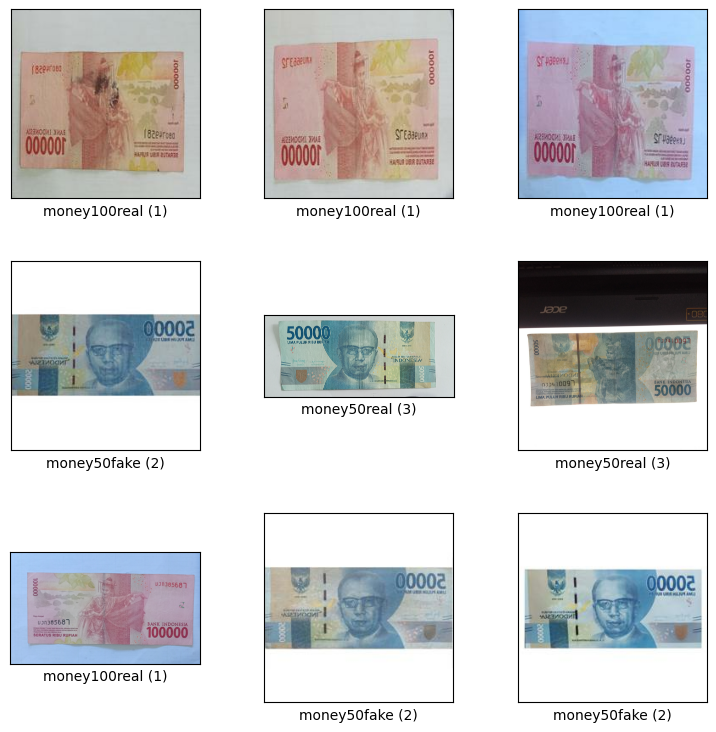

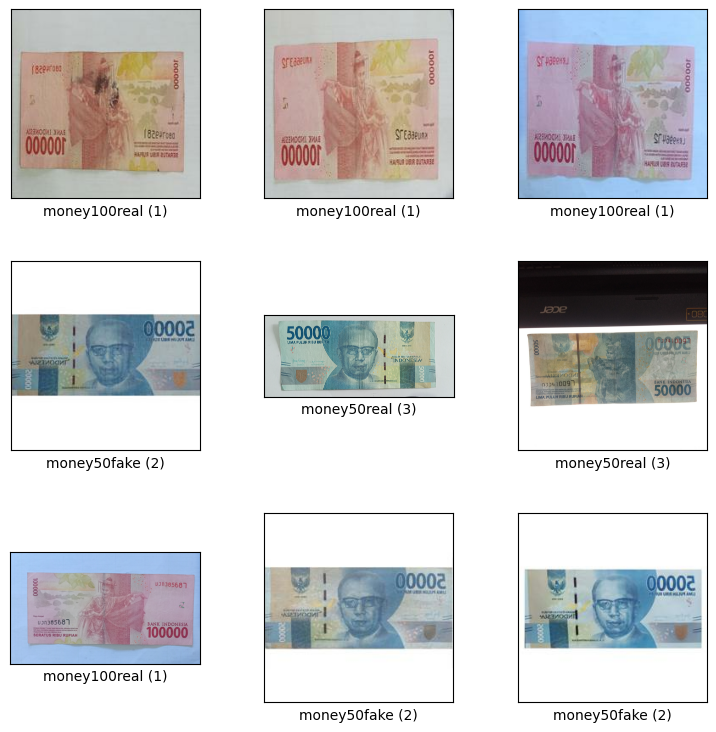

In [ ]:
# Load dataset menggunakan tfds.ImageFolder
import tensorflow_datasets as tfds

builder = tfds.ImageFolder('/content/model3/')
print(builder.info)  # num examples, labels... are automatically calculated
ds = builder.as_dataset(split='training', shuffle_files=True, as_supervised=True)
tfds.show_examples(ds, builder.info)

In [ ]:
train_path=TRAINING_DIR
test_path=VALIDATION_DIR
val_path=TESTING_DIR

In [ ]:
train_x=[]
test_x=[]
val_x=[]

insertArray(train_path, train_x)
insertArray(test_path, test_x)
insertArray(val_path, val_x)

In [ ]:
train_x=np.array(train_x)
test_x=np.array(test_x)
val_x=np.array(val_x)

In [ ]:
#Normalize Data
train_datagen = ImageDataGenerator(
    rescale=1. / 255)
test_datagen = ImageDataGenerator(
    rescale=1. / 255)
val_datagen = ImageDataGenerator(
    rescale=1. / 255)

In [ ]:
# Class mode is set to sparse because the image samples are belong to exactly one class
training_set = train_datagen.flow_from_directory(train_path,
                                                 target_size = (224, 224),
                                                 batch_size = 32,
                                                 class_mode = 'sparse')
test_set = test_datagen.flow_from_directory(test_path,
                                            target_size = (224, 224),
                                            batch_size = 32,
                                            class_mode = 'sparse')
val_set = val_datagen.flow_from_directory(val_path,
                                            target_size = (224, 224),
                                            batch_size = 32,
                                            class_mode = 'sparse')

Found 2496 images belonging to 4 classes.
Found 312 images belonging to 4 classes.
Found 312 images belonging to 4 classes.


In [ ]:
train_y=training_set.classes
test_y=test_set.classes
val_y=val_set.classes

In [ ]:
training_set.class_indices

{'money100fake': 0, 'money100real': 1, 'money50fake': 2, 'money50real': 3}

In [ ]:
train_y.shape,test_y.shape,val_y.shape

((2496,), (312,), (312,))

In [ ]:
vgg = VGG19(input_shape=(224, 224) + tuple([3]), weights='imagenet', include_top=False)

In [ ]:
#do not train the pre-trained layers of VGG-19
for layer in vgg.layers:
    layer.trainable = False

In [ ]:
x = Flatten()(vgg.output)

In [ ]:
#adding output layer.Softmax classifier is used as it is multi-class classification
prediction = Dense(4, activation='softmax')(x)

model = Model(inputs=vgg.input, outputs=prediction)

In [ ]:
model.compile(
  loss='sparse_categorical_crossentropy',
  optimizer="adam",
  metrics=['accuracy']
)

In [ ]:
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=15)
mc = ModelCheckpoint('vggfull_3.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True) 

In [ ]:
# fit the model
history = model.fit(
  train_x,
  train_y,
  validation_data=(val_x,val_y),
  epochs=100,
  callbacks=[mc],
  batch_size=32,shuffle=True)

Epoch 1/100
78/78 [==============================] - ETA: 0s - loss: 4.0861 - accuracy: 0.8029
Epoch 1: val_accuracy improved from -inf to 0.86218, saving model to vggfull_3.h5
78/78 [==============================] - 18s 223ms/step - loss: 4.0861 - accuracy: 0.8029 - val_loss: 3.7515 - val_accuracy: 0.8622
Epoch 2/100
78/78 [==============================] - ETA: 0s - loss: 2.2054 - accuracy: 0.8902
Epoch 2: val_accuracy did not improve from 0.86218
78/78 [==============================] - 15s 189ms/step - loss: 2.2054 - accuracy: 0.8902 - val_loss: 4.3730 - val_accuracy: 0.8301
Epoch 3/100
78/78 [==============================] - ETA: 0s - loss: 1.5707 - accuracy: 0.9187
Epoch 3: val_accuracy did not improve from 0.86218
78/78 [==============================] - 15s 193ms/step - loss: 1.5707 - accuracy: 0.9187 - val_loss: 4.6869 - val_accuracy: 0.8237
Epoch 4/100
78/78 [==============================] - ETA: 0s - loss: 1.1010 - accuracy: 0.9243
Epoch 4: val_accuracy improved from 0.86

In [ ]:
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix
import numpy as np

#predict
y_pred=model.predict(test_x)
y_pred=np.argmax(y_pred,axis=1)

10/10 [==============================] - 2s 152ms/step


In [ ]:
model.evaluate(test_x,test_y,batch_size=32)

10/10 [==============================] - 2s 149ms/step - loss: 9.6627 - accuracy: 0.8718


[9.662687301635742, 0.8717948794364929]

In [ ]:
#get classification report
print(classification_report(y_pred,test_y))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99        59
           1       0.77      0.80      0.79        92
           2       0.72      0.66      0.69        65
           3       1.00      1.00      1.00        96

    accuracy                           0.87       312
   macro avg       0.87      0.87      0.87       312
weighted avg       0.87      0.87      0.87       312



In [ ]:
from sklearn.metrics import confusion_matrix

#Generate the confusion matrix
cf_matrix3 = confusion_matrix(test_y, y_pred)

print(cf_matrix3)

[[59  1  0  0]
 [ 0 74 22  0]
 [ 0 17 43  0]
 [ 0  0  0 96]]


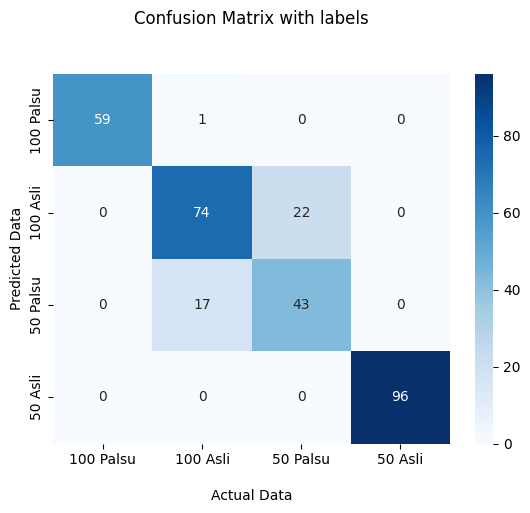

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

ax = sns.heatmap(cf_matrix3, annot=True, cmap='Blues')

ax.set_title('Confusion Matrix with labels\n\n');
ax.set_xlabel('\nActual Data')
ax.set_ylabel('Predicted Data');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['100 Palsu','100 Asli', '50 Palsu', '50 Asli'])
ax.yaxis.set_ticklabels(['100 Palsu','100 Asli', '50 Palsu', '50 Asli'])

## Display the visualization of the Confusion Matrix.
plt.show()

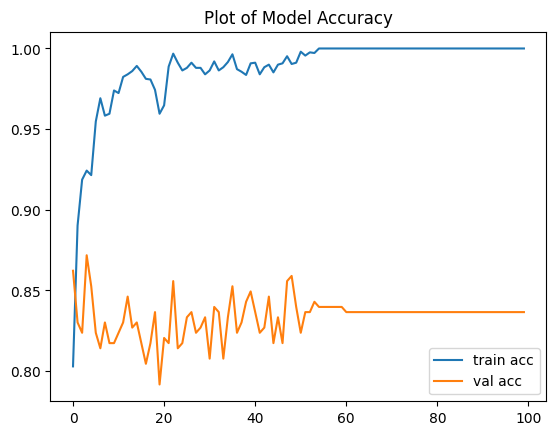

In [ ]:
# accuracies
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.title('Plot of Model Accuracy')
plt.legend()
plt.savefig('vgg-full-3-acc.png')
plt.show()

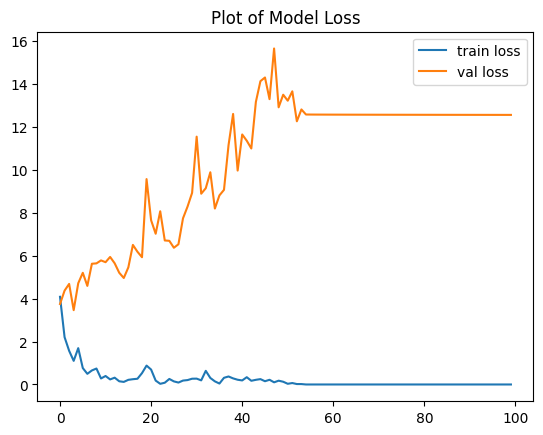

In [ ]:
# loss
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.title('Plot of Model Loss')
plt.legend()
plt.savefig('vgg-full-3-loss.png')
plt.show()

In [ ]:
print('hello')

hello
